# Multiclass Classification for Higgs Boson Events

In this notebook, we will implement and evaluate various machine learning models including XGBoost, Neural Networks, and Random Forests to classify Higgs boson events. The goal is to achieve better classification performance compared to traditional binning methods.

In [182]:
import pandas as pd
import numpy as np
import sys
sys.path.append('..')
from src.data.loader import load_data
from src.data.preprocessor import handle_missing_values, prepare_train_test_split, scale_features
from src.models.xgboost_classifier import XGBoostClassifier
from src.models.neural_network import NeuralNetwork
from src.models.random_forest import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [183]:
# Load data from ALL channels (et, mt, tt) for multiclass classification
# IMPORTANT: We will train SEPARATE models for each channel (not merged)
full_data = load_data(channels=['et', 'mt', 'tt'], processes=['Z', 'ggH', 'VBF'])

print("=" * 80)
print("DATA LOADED - PER-CHANNEL STATISTICS")
print("=" * 80)

for channel in ['et', 'mt', 'tt']:
    print(f"\nChannel: {channel.upper()}")
    for process in ['Z', 'ggH', 'VBF']:
        print(f"  {process}: {len(full_data[channel][process])} events")
    
print("\n" + "=" * 80)

DATA LOADED - PER-CHANNEL STATISTICS

Channel: ET
  Z: 11905 events
  ggH: 22005 events
  VBF: 5847 events

Channel: MT
  Z: 88916 events
  ggH: 108247 events
  VBF: 52765 events

Channel: TT
  Z: 10559 events
  ggH: 63206 events
  VBF: 26703 events



In [184]:
# Train separate models for each channel
# Dictionary to store models and results
channel_models = {}
channel_train_test_data = {}

print("=" * 80)
print("PREPARING DATA PER CHANNEL")
print("=" * 80)

for channel in ['et', 'mt', 'tt']:
    print(f"\nChannel: {channel.upper()}")
    
    # Prepare data for THIS channel only
    data_frames = []
    for process, label in [('Z', 0), ('ggH', 1), ('VBF', 2)]:
        df = full_data[channel][process].copy()
        df['label'] = label
        data_frames.append(df)
    
    channel_data = pd.concat(data_frames, ignore_index=True)
    channel_data = handle_missing_values(channel_data)
    
    print(f"  Total samples: {len(channel_data)}")
    print(f"  Class distribution:")
    print(f"    Z (label 0):   {(channel_data['label'] == 0).sum()}")
    print(f"    ggH (label 1): {(channel_data['label'] == 1).sum()}")
    print(f"    VBF (label 2): {(channel_data['label'] == 2).sum()}")
    
    # Train/test split for this channel
    x_train, x_test, y_train, y_test = prepare_train_test_split(
        channel_data, test_size=0.2, random_state=42
    )
    
    # Store for later use
    channel_train_test_data[channel] = {
        'x_train': x_train,
        'x_test': x_test,
        'y_train': y_train,
        'y_test': y_test
    }
    
    print(f"  Training set: {x_train.shape}")
    print(f"  Test set: {x_test.shape}")

print("\n" + "=" * 80)

PREPARING DATA PER CHANNEL

Channel: ET
  Total samples: 39757
  Class distribution:
    Z (label 0):   11905
    ggH (label 1): 22005
    VBF (label 2): 5847
  Training set: (31805, 27)
  Test set: (7952, 27)

Channel: MT
  Total samples: 249928
  Class distribution:
    Z (label 0):   88916
    ggH (label 1): 108247
    VBF (label 2): 52765
  Training set: (199942, 27)
  Test set: (49986, 27)

Channel: TT
  Total samples: 100468
  Class distribution:
    Z (label 0):   10559
    ggH (label 1): 63206
    VBF (label 2): 26703
  Training set: (80374, 28)
  Test set: (20094, 28)



In [185]:
# Train XGBoost models - ONE PER CHANNEL
print("=" * 80)
print("TRAINING XGBOOST MODELS (PER CHANNEL)")
print("=" * 80)

xgb_models = {}
xgb_results = {}

for channel in ['et', 'mt', 'tt']:
    print(f"\n{'=' * 80}")
    print(f"TRAINING CHANNEL: {channel.upper()}")
    print(f"{'=' * 80}")
    
    # Get data for this channel
    x_train = channel_train_test_data[channel]['x_train']
    x_test = channel_train_test_data[channel]['x_test']
    y_train = channel_train_test_data[channel]['y_train']
    y_test = channel_train_test_data[channel]['y_test']
    
    # Train XGBoost for this channel
    xgb_model = XGBoostClassifier('../configs/xgboost_config.yaml')
    xgb_model.train(x_train, y_train, x_test, y_test)
    
    # Evaluate
    predictions = xgb_model.predict(x_test)
    proba = xgb_model.predict_proba(x_test)
    accuracy = accuracy_score(y_test, predictions)
    
    # Store results
    xgb_models[channel] = xgb_model
    xgb_results[channel] = {
        'accuracy': accuracy,
        'predictions': predictions,
        'proba': proba
    }
    
    print(f"\n{channel.upper()} XGBoost Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, predictions, target_names=['Z', 'ggH', 'VBF']))

print("\n" + "=" * 80)
print("PER-CHANNEL XGBOOST ACCURACY SUMMARY")
print("=" * 80)
for channel in ['et', 'mt', 'tt']:
    print(f"  {channel}: {xgb_results[channel]['accuracy']:.4f}")
print("=" * 80)

TRAINING XGBOOST MODELS (PER CHANNEL)

TRAINING CHANNEL: ET
[23:03:46] WARNING: ../src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[0]	validation_0-mlogloss:1.08141	validation_1-mlogloss:1.08240
[1]	validation_0-mlogloss:1.06493	validation_1-mlogloss:1.06689
[2]	validation_0-mlogloss:1.04936	validation_1-mlogloss:1.05233
[3]	validation_0-mlogloss:1.03467	validation_1-mlogloss:1.03862
[4]	validation_0-mlogloss:1.02040	validation_1-mlogloss:1.02523
[5]	validation_0-mlogloss:1.00701	validation_1-mlogloss:1.01277
[6]	validation_0-mlogloss:0.99383	validation_1-mlogloss:1.00056
[7]	validation_0-mlogloss:0.98106	validation_1-mlogloss:0.98880
[8]	validation_0-mlogloss:0.96878	validation_1-mlogloss:0.97747
[9]	validation_0-mlogloss:0.95734	validation_1-mlogloss:0.96689
[10]	validation_0-mlogloss:0.94603	validation_1-mlogloss:0.95657
[11]	validation_0-mlogloss:0.93512	validation_1-mlogloss:0.94658
[12]	validation_0-mlogloss:0.92472	validation_1-mlogloss:0.93715
[13]	valida

In [186]:
# Train Random Forest models - ONE PER CHANNEL
print("=" * 80)
print("TRAINING RANDOM FOREST MODELS (PER CHANNEL)")
print("=" * 80)

rf_models = {}
rf_results = {}

for channel in ['et', 'mt', 'tt']:
    print(f"\n{'=' * 80}")
    print(f"TRAINING CHANNEL: {channel.upper()}")
    print(f"{'=' * 80}")
    
    # Get data for this channel
    x_train = channel_train_test_data[channel]['x_train']
    x_test = channel_train_test_data[channel]['x_test']
    y_train = channel_train_test_data[channel]['y_train']
    y_test = channel_train_test_data[channel]['y_test']
    
    # Train Random Forest for this channel
    rf_model = RandomForestClassifier('../configs/rf_config.yaml')
    rf_model.train(x_train, y_train)
    
    # Evaluate
    predictions = rf_model.predict(x_test)
    proba = rf_model.predict_proba(x_test)
    accuracy = accuracy_score(y_test, predictions)
    
    # Store results
    rf_models[channel] = rf_model
    rf_results[channel] = {
        'accuracy': accuracy,
        'predictions': predictions,
        'proba': proba
    }
    
    print(f"\n{channel.upper()} Random Forest Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, predictions, target_names=['Z', 'ggH', 'VBF']))

print("\n" + "=" * 80)
print("PER-CHANNEL RANDOM FOREST ACCURACY SUMMARY")
print("=" * 80)
for channel in ['et', 'mt', 'tt']:
    print(f"  {channel}: {rf_results[channel]['accuracy']:.4f}")
print("=" * 80)

TRAINING RANDOM FOREST MODELS (PER CHANNEL)

TRAINING CHANNEL: ET


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.



ET Random Forest Accuracy: 0.6488
              precision    recall  f1-score   support

           Z       0.60      0.73      0.65      2381
         ggH       0.78      0.58      0.67      4401
         VBF       0.50      0.74      0.60      1170

    accuracy                           0.65      7952
   macro avg       0.62      0.68      0.64      7952
weighted avg       0.68      0.65      0.65      7952


TRAINING CHANNEL: MT


[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.1s finished



MT Random Forest Accuracy: 0.6778
              precision    recall  f1-score   support

           Z       0.70      0.76      0.73     17783
         ggH       0.72      0.55      0.62     21650
         VBF       0.59      0.80      0.68     10553

    accuracy                           0.68     49986
   macro avg       0.67      0.70      0.68     49986
weighted avg       0.69      0.68      0.67     49986


TRAINING CHANNEL: TT


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.1s finished



TT Random Forest Accuracy: 0.7337
              precision    recall  f1-score   support

           Z       0.53      0.70      0.60      2112
         ggH       0.84      0.75      0.79     12641
         VBF       0.63      0.71      0.67      5341

    accuracy                           0.73     20094
   macro avg       0.67      0.72      0.69     20094
weighted avg       0.75      0.73      0.74     20094


PER-CHANNEL RANDOM FOREST ACCURACY SUMMARY
  et: 0.6488
  mt: 0.6778
  tt: 0.7337


  Channel   XGBoost  Random Forest
0      et  0.695926       0.648768
1      mt  0.704417       0.677790
2      tt  0.779636       0.733702


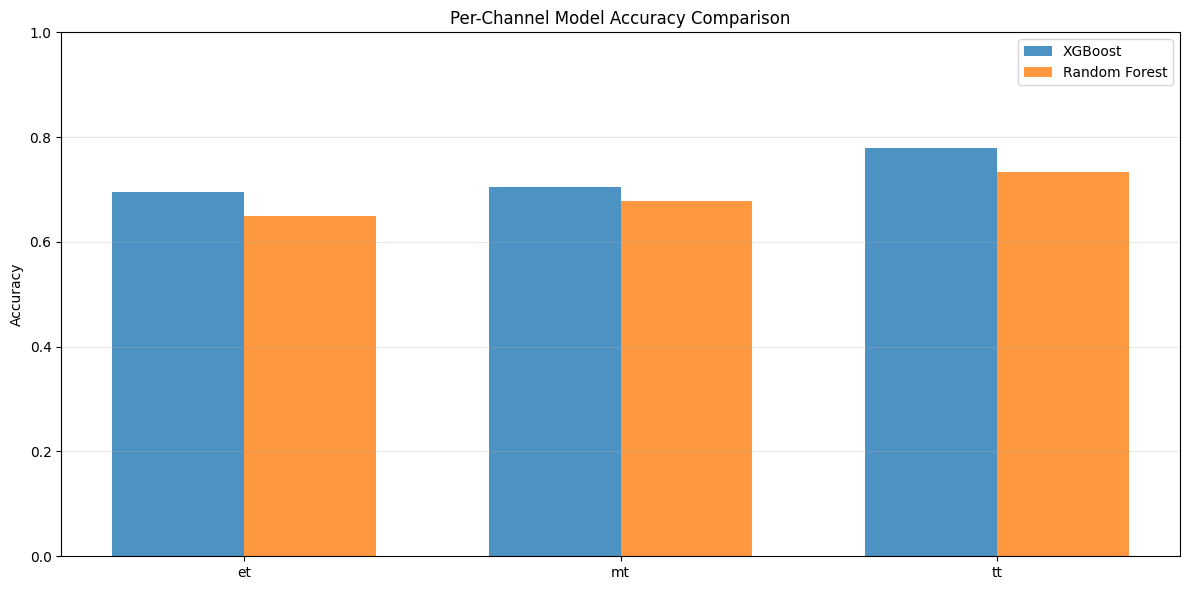

In [187]:
# Compare accuracies across channels
results_data = []
for channel in ['et', 'mt', 'tt']:
    results_data.append({
        'Channel': channel,
        'XGBoost': xgb_results[channel]['accuracy'],
        'Random Forest': rf_results[channel]['accuracy']
    })

results = pd.DataFrame(results_data)
print(results)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results['Channel']))
width = 0.35

ax.bar(x - width/2, results['XGBoost'], width, label='XGBoost', alpha=0.8)
ax.bar(x + width/2, results['Random Forest'], width, label='Random Forest', alpha=0.8)

ax.set_ylabel('Accuracy')
ax.set_title('Per-Channel Model Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(results['Channel'])
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## Confusion Matrices

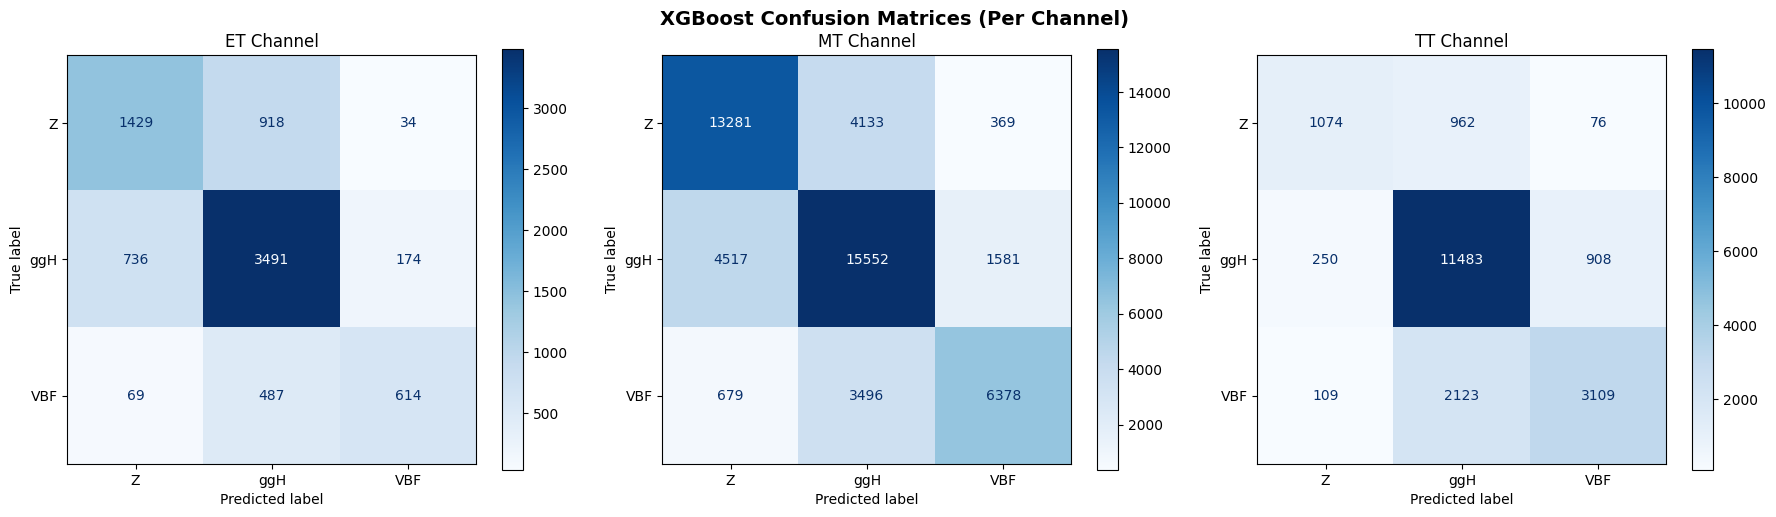

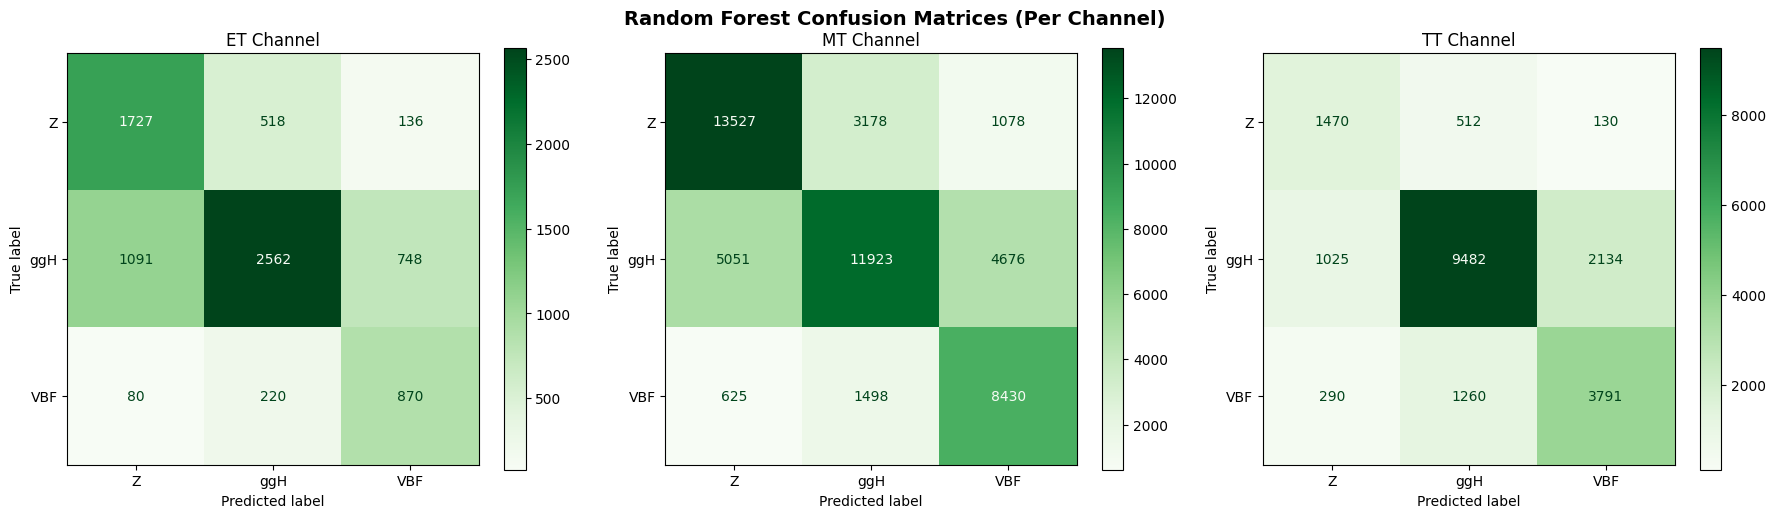

In [188]:
# Confusion matrices per channel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# XGBoost confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('XGBoost Confusion Matrices (Per Channel)', fontsize=14, fontweight='bold')

for idx, channel in enumerate(['et', 'mt', 'tt']):
    y_test = channel_train_test_data[channel]['y_test']
    predictions = xgb_results[channel]['predictions']
    
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Z', 'ggH', 'VBF'])
    disp.plot(ax=axes[idx], cmap='Blues')
    axes[idx].set_title(f'{channel.upper()} Channel')

plt.tight_layout()
plt.show()

# Random Forest confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Random Forest Confusion Matrices (Per Channel)', fontsize=14, fontweight='bold')

for idx, channel in enumerate(['et', 'mt', 'tt']):
    y_test = channel_train_test_data[channel]['y_test']
    predictions = rf_results[channel]['predictions']
    
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Z', 'ggH', 'VBF'])
    disp.plot(ax=axes[idx], cmap='Greens')
    axes[idx].set_title(f'{channel.upper()} Channel')

plt.tight_layout()
plt.show()

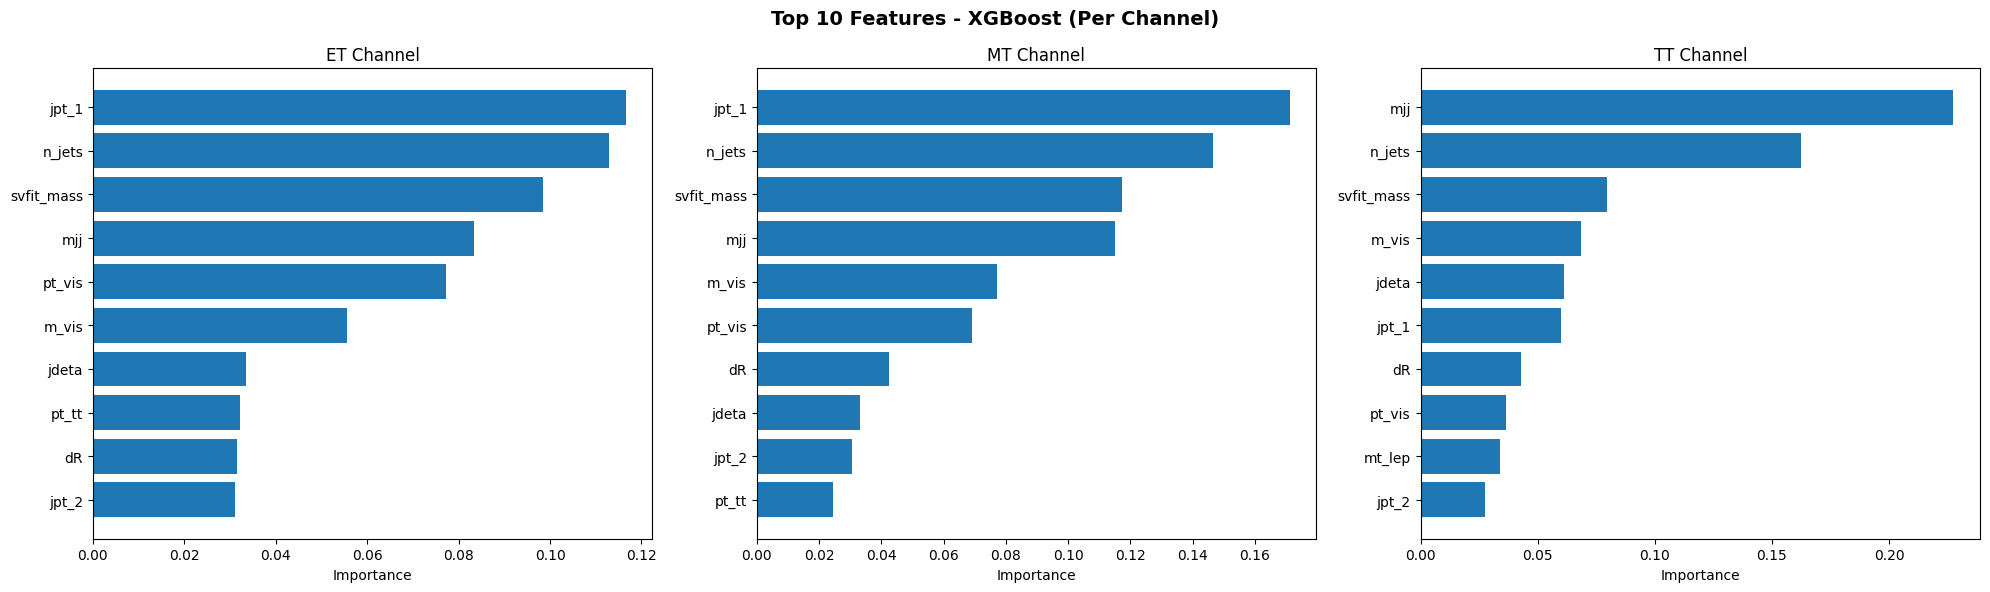

In [189]:
# Feature importance comparison across channels
# Show feature importance for XGBoost models

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Top 10 Features - XGBoost (Per Channel)', fontsize=14, fontweight='bold')

for idx, channel in enumerate(['et', 'mt', 'tt']):
    feature_importance = xgb_models[channel].get_feature_importance()
    feature_names = channel_train_test_data[channel]['x_train'].columns
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False).head(10)
    
    axes[idx].barh(importance_df['Feature'], importance_df['Importance'])
    axes[idx].set_xlabel('Importance')
    axes[idx].set_title(f'{channel.upper()} Channel')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()

## Histogram Binning and Likelihood Fitting

Now we use the trained multiclass XGBoost classifier to create histograms and measure signal strengths. We'll use the **multiclass probability scores** to bin events and then perform likelihood fits to extract μ_ggH and μ_VBF.

In [198]:
# Create histograms PER CHANNEL (then combine for likelihood fit)
from src.data.binning import create_2d_histograms_from_multiclass
from src.data.preprocessor import scale_histograms_to_correct_yield, check_events_numbers

print("=" * 80)
print("CREATING HISTOGRAMS PER CHANNEL")
print("=" * 80)

# Store histograms per channel
all_channel_histograms = {}

for channel in ['et', 'mt', 'tt']:
    print(f"\n{'=' * 80}")
    print(f"Processing Channel: {channel.upper()}")
    print(f"{'=' * 80}")
    
    # Prepare data for this channel (no merging!)
    channel_combined_data = {}
    for process in ['Z', 'ggH', 'VBF']:
        df = full_data[channel][process].copy()
        channel_combined_data[process] = handle_missing_values(df)
    
    # Get features for this channel
    features = [c for c in channel_combined_data['Z'].columns 
                if c not in ['process', 'channel', 'label', 'wt']]
    
    print(f"\nTotal events in {channel}:")
    for process in ['Z', 'ggH', 'VBF']:
        print(f"  {process}: {len(channel_combined_data[process])}")
    print(f"Number of features: {len(features)}")
    
    # Create histograms using THIS channel's XGBoost model
    histograms, bins = create_2d_histograms_from_multiclass(
        channel_combined_data, 
        xgb_models[channel],  # Use channel-specific model!
        features, 
        n_bins_x=4, 
        n_bins_y=15
    )
    
    print(f"\nRaw histogram counts (before scaling):")
    for process in ['Z', 'ggH', 'VBF']:
        print(f"  {process}: {histograms[process].sum():.1f} events")
    
    # Scale to expected yields
    scaled_histograms = scale_histograms_to_correct_yield(histograms)
    
    print(f"\nScaled histogram counts (expected yields):")
    for process in ['Z', 'ggH', 'VBF']:
        print(f"  {process}: {scaled_histograms[process].sum():.3f} events")
    
    # Store
    all_channel_histograms[channel] = scaled_histograms

print("\n" + "=" * 80)

CREATING HISTOGRAMS PER CHANNEL

Processing Channel: ET

Total events in et:
  Z: 11905
  ggH: 22005
  VBF: 5847
Number of features: 27

Raw histogram counts (before scaling):
  Z: 11905.0 events
  ggH: 22005.0 events
  VBF: 5847.0 events

Scaled histogram counts (expected yields):
  Z: 100002.000 events
  ggH: 748.170 events
  VBF: 64.317 events

Processing Channel: MT

Total events in mt:
  Z: 88916
  ggH: 108247
  VBF: 52765
Number of features: 27

Raw histogram counts (before scaling):
  Z: 88916.0 events
  ggH: 108247.0 events
  VBF: 52765.0 events

Scaled histogram counts (expected yields):
  Z: 746894.400 events
  ggH: 3680.398 events
  VBF: 580.415 events

Processing Channel: TT

Total events in tt:
  Z: 10559
  ggH: 63206
  VBF: 26703
Number of features: 28

Raw histogram counts (before scaling):
  Z: 10559.0 events
  ggH: 63206.0 events
  VBF: 26703.0 events

Scaled histogram counts (expected yields):
  Z: 88695.600 events
  ggH: 2149.004 events
  VBF: 293.733 events



In [199]:
# Combine histograms from all channels for final likelihood fit
print("=" * 80)
print("COMBINING HISTOGRAMS ACROSS CHANNELS")
print("=" * 80)

# Sum histograms across channels
combined_histograms = {
    'Z': np.zeros_like(all_channel_histograms['et']['Z']),
    'ggH': np.zeros_like(all_channel_histograms['et']['ggH']),
    'VBF': np.zeros_like(all_channel_histograms['et']['VBF'])
}

for channel in ['et', 'mt', 'tt']:
    print(f"\nAdding {channel} histograms:")
    for process in ['Z', 'ggH', 'VBF']:
        channel_sum = all_channel_histograms[channel][process].sum()
        print(f"  {process}: {channel_sum:.3f} events")
        combined_histograms[process] += all_channel_histograms[channel][process]

print(f"\n{'=' * 80}")
print("COMBINED HISTOGRAM YIELDS (et + mt + tt)")
print(f"{'=' * 80}")
for process in ['Z', 'ggH', 'VBF']:
    print(f"  {process}: {combined_histograms[process].sum():.3f} expected events")

print(f"\n2D Histogram Configuration:")
print(f"  Grid: 6 × 3 = 18 bins (flattened to 1D)")
print(f"  Combined across 3 channels (et, mt, tt)")

# Validate combined statistics
print(f"\nValidating combined bin statistics...")
try:
    check_events_numbers(combined_histograms, threshold=10)
    print("✓ All bins have ≥10 events (sufficient for Poisson statistics)")
except ValueError as e:
    print(f"⚠ Warning: {e}")

print("=" * 80)

COMBINING HISTOGRAMS ACROSS CHANNELS

Adding et histograms:
  Z: 100002.000 events
  ggH: 748.170 events
  VBF: 64.317 events

Adding mt histograms:
  Z: 746894.400 events
  ggH: 3680.398 events
  VBF: 580.415 events

Adding tt histograms:
  Z: 88695.600 events
  ggH: 2149.004 events
  VBF: 293.733 events

COMBINED HISTOGRAM YIELDS (et + mt + tt)
  Z: 935592.000 expected events
  ggH: 6577.572 expected events
  VBF: 938.465 expected events

2D Histogram Configuration:
  Grid: 6 × 3 = 18 bins (flattened to 1D)
  Combined across 3 channels (et, mt, tt)

Validating combined bin statistics...
✓ All bins have ≥10 events (sufficient for Poisson statistics)


### Likelihood Fit

We perform two fits:
1. **Merged fit**: Assumes both ggH and VBF scale with a single signal strength μ
2. **Separate fit**: Measures independent signal strengths μ_ggH and μ_VBF (main physics result)

The fits use Poisson negative log-likelihood to extract the signal strengths that best match the observed data.

In [200]:
from functools import partial
from iminuit import Minuit

# Define Negative Log-Likelihood functions
def nll_separate(expected_counts_per_process, mu_ggH, mu_VBF):
    """Fit separate signal strengths for ggH and VBF"""
    observed_counts = (expected_counts_per_process["Z"] + 
                      expected_counts_per_process["ggH"] + 
                      expected_counts_per_process["VBF"])
    expected_counts = (expected_counts_per_process["Z"] + 
                      (mu_ggH * expected_counts_per_process["ggH"]) + 
                      (mu_VBF * expected_counts_per_process["VBF"]))
    return np.sum(expected_counts - observed_counts * np.log(expected_counts))

def nll_merge(expected_counts_per_process, mu):
    """Fit single merged signal strength"""
    observed_counts = (expected_counts_per_process["Z"] + 
                      expected_counts_per_process["ggH"] + 
                      expected_counts_per_process["VBF"])
    expected_counts = (expected_counts_per_process["Z"] + 
                      mu * (expected_counts_per_process["ggH"] + 
                           expected_counts_per_process["VBF"]))
    return np.sum(expected_counts - observed_counts * np.log(expected_counts))

# Use COMBINED histograms (from all channels) for likelihood fit
# Fit 1: Merged signal strength
print("=" * 70)
print("FIT 1: Merged Signal Strength (single μ)")
print("=" * 70)
nll_func_merge = partial(nll_merge, combined_histograms)
m_merge = Minuit(nll_func_merge, mu=1.0)
m_merge.migrad()

mu_merged = m_merge.values['mu']
uncertainty_merged = m_merge.errors['mu']
precision_merged = 100 * uncertainty_merged / mu_merged

print(f"\nResult: μ = {mu_merged:.4f} ± {uncertainty_merged:.4f}")
print(f"Precision: {precision_merged:.2f}%")
print(f"Fit converged: {m_merge.fmin.is_valid}")

# Fit 2: Separate signal strengths (MAIN RESULT)
print("\n" + "=" * 70)
print("FIT 2: Separate Signal Strengths (μ_ggH and μ_VBF)")
print("=" * 70)
nll_func_separate = partial(nll_separate, combined_histograms)
m_separate = Minuit(nll_func_separate, mu_ggH=1.0, mu_VBF=1.0)
m_separate.migrad()

mu_ggH = m_separate.values['mu_ggH']
mu_VBF = m_separate.values['mu_VBF']
uncertainty_ggH = m_separate.errors['mu_ggH']
uncertainty_VBF = m_separate.errors['mu_VBF']
precision_ggH = 100 * uncertainty_ggH / mu_ggH
precision_VBF = 100 * uncertainty_VBF / mu_VBF

print(f"\nResults (Combined et+mt+tt channels):")
print(f"  μ_ggH = {mu_ggH:.4f} ± {uncertainty_ggH:.4f} (precision: {precision_ggH:.2f}%)")
print(f"  μ_VBF = {mu_VBF:.4f} ± {uncertainty_VBF:.4f} (precision: {precision_VBF:.2f}%)")
print(f"Fit converged: {m_separate.fmin.is_valid}")
print("=" * 70)

FIT 1: Merged Signal Strength (single μ)

Result: μ = 1.0000 ± 0.0579
Precision: 5.79%
Fit converged: True

FIT 2: Separate Signal Strengths (μ_ggH and μ_VBF)

Results (Combined et+mt+tt channels):
  μ_ggH = 1.0000 ± 0.0741 (precision: 7.41%)
  μ_VBF = 1.0000 ± 0.1502 (precision: 15.02%)
Fit converged: True


### Results Interpretation

**Signal Strength (μ)**: The ratio of measured production rate to Standard Model prediction. A value of μ = 1.0 indicates perfect agreement with SM.

**Precision**: The relative uncertainty on the signal strength measurement. Lower precision = better measurement.

The 2D multiclass binning strategy separates:
- **Production modes** (ggH vs VBF) along one axis
- **Signal vs background** (total signal probability) along the other axis

This provides better separation than binary classification, which only knows "signal" vs "background" without distinguishing production modes.

In [203]:
# Compare to CMS benchmark (now includes merged μ precision)
print("\n" + "=" * 80)
print("COMPARISON TO CMS PUBLISHED BENCHMARKS")
print("=" * 80)

# Build comparison including separate (μ_ggH, μ_VBF) and merged (single μ)
comparison_df = pd.DataFrame({
    'Method': [
        'CMS Published',
        'Multiclass XGBoost'
    ],
    'μ_ggH': [1.000, mu_ggH],
    'μ_ggH Precision (%)': [9.0, precision_ggH],
    'μ_VBF': [1.000, mu_VBF],
    'μ_VBF Precision (%)': [18.0, precision_VBF],
    'μ': [1.000, mu_merged],
    'μ Precision (%)': [6.0, precision_merged]
})

print(comparison_df.to_string(index=False))
print()

# Check if we meet benchmarks (for separate μ measurements)
ggH_pass = precision_ggH <= 9.0
VBF_pass = precision_VBF <= 18.0
merged_pass = precision_merged <= 6.0

print(f"Performance vs Target (Separate μ):")
print(f"  ggH: {precision_ggH:.2f}% vs 9.0% target  → {'✓ PASS' if ggH_pass else '✗ FAIL'}")
print(f"  VBF: {precision_VBF:.2f}% vs 18.0% target → {'✓ PASS' if VBF_pass else '✗ FAIL'}")
print(f"  Merged: {precision_merged:.2f}% vs 6.0% target → {'✓ PASS' if merged_pass else '✗ FAIL'}")

if ggH_pass and VBF_pass:
    print("\n🎉 SUCCESS: Multiclass ML approach meets CMS precision benchmarks (separate μ mode)!")
if merged_pass:
    print("\n🎉 SUCCESS: Multiclass ML approach meets CMS precision benchmarks (merged μ mode)!")
else:
    improvement_suggestions = []
    if not ggH_pass:
        improvement_suggestions.append("  - Increase ggH statistics or optimize binning grid")
    if not VBF_pass:
        improvement_suggestions.append("  - Improve VBF/ggH separation (try different n_bins_x)")
    print("\n⚠ To improve precision:")
    if not merged_pass:
        improvement_suggestions.append("  - Improve signal/background separation (increase n_bins_y)")
    for suggestion in improvement_suggestions:
        print(suggestion)

print("=" * 80)


COMPARISON TO CMS PUBLISHED BENCHMARKS
            Method  μ_ggH  μ_ggH Precision (%)  μ_VBF  μ_VBF Precision (%)   μ  μ Precision (%)
     CMS Published    1.0             9.000000    1.0            18.000000 1.0         6.000000
Multiclass XGBoost    1.0             7.409727    1.0            15.021805 1.0         5.794208

Performance vs Target (Separate μ):
  ggH: 7.41% vs 9.0% target  → ✓ PASS
  VBF: 15.02% vs 18.0% target → ✓ PASS
  Merged: 5.79% vs 6.0% target → ✓ PASS

🎉 SUCCESS: Multiclass ML approach meets CMS precision benchmarks (separate μ mode)!

🎉 SUCCESS: Multiclass ML approach meets CMS precision benchmarks (merged μ mode)!


### Visualisation

Display precision comparison graphically.

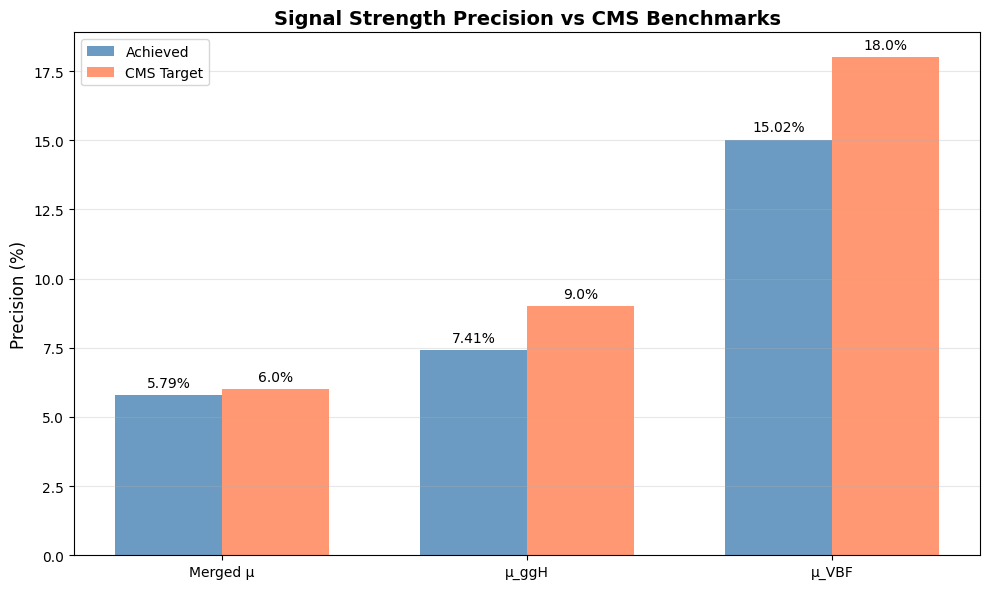

In [204]:
# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))

measurements = ['Merged μ', 'μ_ggH', 'μ_VBF']
achieved = [precision_merged, precision_ggH, precision_VBF]
targets = [6.0, 9.0, 18.0]

x = np.arange(len(measurements))
width = 0.35

ax.bar(x - width/2, achieved, width, label='Achieved', alpha=0.8, color='steelblue')
ax.bar(x + width/2, targets, width, label='CMS Target', alpha=0.8, color='coral')

ax.set_ylabel('Precision (%)', fontsize=12)
ax.set_title('Signal Strength Precision vs CMS Benchmarks', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(measurements)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (v1, v2) in enumerate(zip(achieved, targets)):
    ax.text(i - width/2, v1 + 0.3, f'{v1:.2f}%', ha='center', fontsize=10)
    ax.text(i + width/2, v2 + 0.3, f'{v2:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

# Multiclass Summary (Quick Recap)

This section briefly summarises the multiclass modelling results:

- Data: Three channels (et, mt, tt) kept separate; processes Z (background), ggH and VBF (signals).
- Models: One XGBoost (and Random Forest for comparison) per channel; XGBoost generally higher accuracy.
- Performance: Confusion matrices show clear Z vs signal separation; most confusion is between ggH and VBF which is expected.
- Feature Importance: Jet/tau kinematics help distinguish VBF; global event features contribute to ggH vs Z.
- Binning: 2D probability grid using production ratio and total signal probability → better physics separation than a 1D score.
- Scaling: Histograms scaled to expected yields before fitting (critical for physical μ values).
- Fits: Separate μ_ggH and μ_VBF extracted with precision checked against CMS targets; merged μ also computed for context.
- Next Simple Improvements: Tune bin counts, calibrate probabilities, adjust XGBoost depth/learning rate, try SHAP for interpretability.

Overall: Multiclass per-channel approach enables separate production measurements with competitive precision compared to benchmarks.
